In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
import sklearn.metrics

/home/shikha/snap/jupyter/common/lib/python3.7/site-packages/joblib/_multiprocessing_helpers.py:45: UserWarning: [Errno 13] Permission denied.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


In [2]:
data = pd.read_csv('../notebooks/clean_df.csv')
data.head()

,Unnamed: 0,Sample No.,Patient ID,Study ID,Age,Gender,BMI,Symptoms Presented,Symptoms Present?,Fever,...,ALKALINE PHOSPHATASE,C-REACTIVE PROTEINS,ECG,CXR,CORADS SCORE ON HRCT,PATIENT CATEGORY,PLASMA THERAPY,Age Above 60?,Temp Groups,CORADS 6
0,0,1013,IGIB1040201013,IGIB1040201013-1,0.551724,1,0.436782,"fever, cough,breathlessness",1,1,...,0.127089,0.152271,sinus rhythm,normal,4.0,5a,No,0,0.2,0.0
1,1,1014,IGIB1040201014,IGIB1040201014-1,0.241379,0,0.804598,asymptomatic,0,0,...,0.172501,0.009346,sinus rhythm,normal,0.0,5b,No,0,0.6,0.0
2,2,1015,IGIB1040201015,IGIB1040201015-1,0.264368,1,0.402299,asymptomatic,0,0,...,0.259224,0.026437,sinus rhythm,normal,0.0,5b,No,0,0.4,0.0
3,3,1016,IGIB1040201016,IGIB1040201016-1,0.781609,1,0.321839,"fever, cough,breathlessness",1,1,...,0.366446,0.443161,sinus rhythm,normal,5.0,4,No,1,0.4,0.0
4,4,1060,IGIB1040201060,IGIB1040201060-1,0.505747,1,1.000000,"fever,cough",1,1,...,0.546200,0.430297,sinus rhythm,normal,5.0,4,No,0,0.8,0.0


In [3]:
data.drop(columns=['Unnamed: 0'], inplace = True)

## Model

In [4]:
def model_perf(x,y,model):
    cm = metrics.confusion_matrix(y, model.predict(x))
    plt.figure
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    plt.savefig('covidseverity.png')
    accuracy = model.score(x,y)
    precision,recall,f1,support = sklearn.metrics.precision_recall_fscore_support(y, model.predict(x),average='binary')
    print("Accuracy Score = ",accuracy)
    print("Precision Score = ",precision)    
    print("Recall Score = ",recall)    
    print("F1 Score = ",f1)

In [5]:
def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=10, scoring_fit='neg_mean_squared_error',
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    if do_probabilities:
      pred = fitted_model.predict_proba(X_test_data)
    else:
      pred = fitted_model.predict(X_test_data)
    
    return fitted_model, pred

In [6]:
def visualize(x,y, model):
    
        cm = metrics.confusion_matrix(y, model.predict(x))
        plt.figure
        sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
        plt.ylabel('Actual label');
        plt.xlabel('Predicted label');
        plt.savefig('covidseverity.png')
        
        
def ttmodel(X, Y, lm, n):
    
        train_accuracy = [0]*n
        train_precision = [0]*n
        train_recall = [0]*n
        train_f1 = [0]*n

        test_accuracy = [0]*n
        test_precision = [0]*n
        test_recall = [0]*n
        test_f1 = [0]*n
        
        for i in range(n):
            x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25)

            lm.fit(x_train,y_train)

            train_accuracy[i] = lm.score(x_train,y_train)
            train_precision[i], train_recall[i], train_f1[i], s = sklearn.metrics.precision_recall_fscore_support(y_train, lm.predict(x_train), average='weighted')

            test_accuracy[i] = lm.score(x_test,y_test)
            test_precision[i], test_recall[i], test_f1[i], s = sklearn.metrics.precision_recall_fscore_support(y_test, lm.predict(x_test), average='weighted')

        print("Average training statistics over",n,"runs of the SVM model - ")
        print("Accuracy Score = ", sum(train_accuracy)/n)
        print("Precision Score = ", sum(train_precision)/n)    
        print("Recall Score = ", sum(train_recall)/n)   
        print("F1 Score = ", sum(train_f1)/n) 

        print()
        
        print("Average testing statistics over",n,"runs of the SVM model - ")
        print("Accuracy Score = ", sum(test_accuracy)/n)
        print("Precision Score = ", sum(test_precision)/n)    
        print("Recall Score = ", sum(test_recall)/n)   
        print("F1 Score = ", sum(test_f1)/n) 
        
        visualize(x_test, y_test, lm)
        
        
def cvmodel(X, Y, lm, cv):
    
        from sklearn.model_selection import cross_validate
        scoring = ['f1','roc_auc']
        scores = cross_validate(lm, X, Y, cv=cv, scoring = scoring, return_train_score=True)
        
        for k,v in scores.items():
            ans = [min(v),sum(v)/len(v),max(v)]
            print(k,"=",ans)
            print()

## Initial Factors + Symptoms and Comorbidities + Blood

In [62]:
X = data[['Age Above 60?','Gender','Temp Groups','Respiratory rate(breaths per minute)','Symptoms Present?','Co-morbidity?','Cough','Breathlessness','Hypertension','C-REACTIVE PROTEINS','UREA']]
Y = data['Outcome']
trainset =  pd.read_csv('../notebooks/train.csv')
testset =  pd.read_csv('../notebooks/test.csv')

Xtrain = trainset[['Age Above 60?','Gender','Temp Groups','Respiratory rate(breaths per minute)','Symptoms Present?','Co-morbidity?','Cough','Breathlessness','Hypertension','C-REACTIVE PROTEINS','UREA']]
ytrain = trainset['Outcome']

Xtest = testset[['Age Above 60?','Gender','Temp Groups','Respiratory rate(breaths per minute)','Symptoms Present?','Co-morbidity?','Cough','Breathlessness','Hypertension','C-REACTIVE PROTEINS','UREA']]
ytest = testset['Outcome']

In [79]:
model = SVC()
param_grid = {'C': [0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000], 
              'gamma': [3, 1, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 'scale','auto'],
              'kernel': ['rbf','linear','sigmoid','poly']} 

model, pred = algorithm_pipeline(Xtrain, Xtest, ytrain, ytest, model, 
                                 param_grid, cv = 5, scoring_fit = 'f1')

# Root Mean Squared Error
print(np.sqrt(-model.best_score_))
print(model.best_params_)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[CV] END .........................C=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, gamma=3, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=3, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=3, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=3, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=3, kernel=linear; total time=   0.0s
[CV] END .....................C=0.1, gamma=3, kernel=sigmoid; total time=   0.0s
[CV] END .....................C=0.1, gamma=3,

[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ..................C=0.1, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ..................C=0.1, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ..................C=0.1, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ..................C=0.1, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ..................C=0.1, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END .....................C=0.1, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ...................

[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ..................C=0.1, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END ..................C=0.1, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END ..................C=0.1, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END ..................C=0.1, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END ..................C=0.1, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END .....................C=0.1, gamma=auto, kernel=poly; total time=   0.0s
[CV] END .....................C=0.1, gamma=auto, kernel=poly; total time=   0.0s
[CV] END .....................C=0.1, gamma=auto, kernel=poly; total time=   0.0s
[CV] END .....................C=0.1, gamma=auto, kernel=poly; total time=   0.0s
[CV] END .....................C=0.1, gamma=auto, kernel=poly; total time=   0.0s
[CV] END .........................C=0.3, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...................

[CV] END .....................C=0.3, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .....................C=0.3, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .....................C=0.3, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .....................C=0.3, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .....................C=0.3, gamma=0.003, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.3, gamma=0.003, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.3, gamma=0.003, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.3, gamma=0.003, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.3, gamma=0.003, kernel=rbf; total time=   0.0s
[CV] END ..................C=0.3, gamma=0.003, kernel=linear; total time=   0.0s
[CV] END ..................C=0.3, gamma=0.003, kernel=linear; total time=   0.0s
[CV] END ..................C=0.3, gamma=0.003, kernel=linear; total time=   0.0s
[CV] END ..................C

[CV] END ...................C=0.3, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ..................C=0.3, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END ..................C=0.3, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END ..................C=0.3, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END ..................C=0.3, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END ..................C=0.3, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END .....................C=0.3, gamma=auto, kernel=poly; total time=   0.0s
[CV] END .....................C=0.3, gamma=auto, kernel=poly; total time=   0.0s
[CV] END .....................C=0.3, gamma=auto, kernel=poly; total time=   0.0s
[CV] END .....................C=0.3, gamma=auto, kernel=poly; total time=   0.0s
[CV] END .....................C=0.3, gamma=auto, kernel=poly; total time=   0.0s
[CV] END ...........................C=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...................

[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ....................C=1, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ....................C=1, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ...................

[CV] END ...................C=1, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END ......................C=1, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ......................C=1, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ......................C=1, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ......................C=1, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ......................C=1, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ........................C=1, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ........................C=1, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ........................C=1, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ........................C=1, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ........................C=1, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .....................C=1, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ...................

[CV] END ....................C=3, gamma=0.03, kernel=sigmoid; total time=   0.0s
[CV] END ....................C=3, gamma=0.03, kernel=sigmoid; total time=   0.0s
[CV] END .......................C=3, gamma=0.03, kernel=poly; total time=   0.0s
[CV] END .......................C=3, gamma=0.03, kernel=poly; total time=   0.0s
[CV] END .......................C=3, gamma=0.03, kernel=poly; total time=   0.0s
[CV] END .......................C=3, gamma=0.03, kernel=poly; total time=   0.0s
[CV] END .......................C=3, gamma=0.03, kernel=poly; total time=   0.0s
[CV] END ........................C=3, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ........................C=3, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ........................C=3, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ........................C=3, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ........................C=3, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ...................

[CV] END ......................C=3, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ......................C=3, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ......................C=3, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ......................C=3, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ........................C=3, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ........................C=3, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ........................C=3, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ........................C=3, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ........................C=3, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .....................C=3, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .....................C=3, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .....................C=3, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ...................

[CV] END ...................C=10, gamma=0.03, kernel=sigmoid; total time=   0.0s
[CV] END ...................C=10, gamma=0.03, kernel=sigmoid; total time=   0.0s
[CV] END ...................C=10, gamma=0.03, kernel=sigmoid; total time=   0.0s
[CV] END ......................C=10, gamma=0.03, kernel=poly; total time=   0.0s
[CV] END ......................C=10, gamma=0.03, kernel=poly; total time=   0.0s
[CV] END ......................C=10, gamma=0.03, kernel=poly; total time=   0.0s
[CV] END ......................C=10, gamma=0.03, kernel=poly; total time=   0.0s
[CV] END ......................C=10, gamma=0.03, kernel=poly; total time=   0.0s
[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ...................

[CV] END ....................C=10, gamma=0.0001, kernel=poly; total time=   0.0s
[CV] END ....................C=10, gamma=0.0001, kernel=poly; total time=   0.0s
[CV] END ....................C=10, gamma=0.0001, kernel=poly; total time=   0.0s
[CV] END ....................C=10, gamma=0.0001, kernel=poly; total time=   0.0s
[CV] END ....................C=10, gamma=0.0001, kernel=poly; total time=   0.0s
[CV] END ......................C=10, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ......................C=10, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ......................C=10, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ......................C=10, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ......................C=10, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ...................C=10, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ...................C=10, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ...................

[CV] END ....................C=30, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ....................C=30, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ....................C=30, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ....................C=30, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END .......................C=30, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .......................C=30, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .......................C=30, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .......................C=30, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .......................C=30, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .......................C=30, gamma=0.03, kernel=rbf; total time=   0.0s
[CV] END .......................C=30, gamma=0.03, kernel=rbf; total time=   0.0s
[CV] END .......................C=30, gamma=0.03, kernel=rbf; total time=   0.0s
[CV] END ...................

[CV] END .................C=30, gamma=0.0001, kernel=sigmoid; total time=   0.0s
[CV] END .................C=30, gamma=0.0001, kernel=sigmoid; total time=   0.0s
[CV] END .................C=30, gamma=0.0001, kernel=sigmoid; total time=   0.0s
[CV] END ....................C=30, gamma=0.0001, kernel=poly; total time=   0.0s
[CV] END ....................C=30, gamma=0.0001, kernel=poly; total time=   0.0s
[CV] END ....................C=30, gamma=0.0001, kernel=poly; total time=   0.0s
[CV] END ....................C=30, gamma=0.0001, kernel=poly; total time=   0.0s
[CV] END ....................C=30, gamma=0.0001, kernel=poly; total time=   0.0s
[CV] END ......................C=30, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ......................C=30, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ......................C=30, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ......................C=30, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ...................

[CV] END ....................C=100, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ....................C=100, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ....................C=100, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ....................C=100, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ....................C=100, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ...................C=100, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ...................C=100, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ...................C=100, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ...................C=100, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ...................C=100, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ......................C=100, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ......................C=100, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...................

[CV] END ...................C=100, gamma=0.0003, kernel=poly; total time=   0.0s
[CV] END ...................C=100, gamma=0.0003, kernel=poly; total time=   0.0s
[CV] END ...................C=100, gamma=0.0003, kernel=poly; total time=   0.0s
[CV] END ...................C=100, gamma=0.0003, kernel=poly; total time=   0.0s
[CV] END ....................C=100, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END ....................C=100, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END ....................C=100, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END ....................C=100, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END ....................C=100, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END .................C=100, gamma=0.0001, kernel=linear; total time=   0.0s
[CV] END .................C=100, gamma=0.0001, kernel=linear; total time=   0.0s
[CV] END .................C=100, gamma=0.0001, kernel=linear; total time=   0.0s
[CV] END .................C=

[CV] END .......................C=300, gamma=0.3, kernel=rbf; total time=   0.0s
[CV] END .......................C=300, gamma=0.3, kernel=rbf; total time=   0.0s
[CV] END ....................C=300, gamma=0.3, kernel=linear; total time=   0.0s
[CV] END ....................C=300, gamma=0.3, kernel=linear; total time=   0.0s
[CV] END ....................C=300, gamma=0.3, kernel=linear; total time=   0.0s
[CV] END ....................C=300, gamma=0.3, kernel=linear; total time=   0.0s
[CV] END ....................C=300, gamma=0.3, kernel=linear; total time=   0.0s
[CV] END ...................C=300, gamma=0.3, kernel=sigmoid; total time=   0.0s
[CV] END ...................C=300, gamma=0.3, kernel=sigmoid; total time=   0.0s
[CV] END ...................C=300, gamma=0.3, kernel=sigmoid; total time=   0.0s
[CV] END ...................C=300, gamma=0.3, kernel=sigmoid; total time=   0.0s
[CV] END ...................C=300, gamma=0.3, kernel=sigmoid; total time=   0.0s
[CV] END ...................

[CV] END ..................C=300, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ..................C=300, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END .................C=300, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END .................C=300, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END .................C=300, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END .................C=300, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END .................C=300, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ....................C=300, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ....................C=300, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ....................C=300, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ....................C=300, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ....................C=300, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ...................

[CV] END ........................C=1000, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=1000, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=1000, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=1000, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .....................C=1000, gamma=1, kernel=linear; total time=   0.0s
[CV] END .....................C=1000, gamma=1, kernel=linear; total time=   0.0s
[CV] END .....................C=1000, gamma=1, kernel=linear; total time=   0.0s
[CV] END .....................C=1000, gamma=1, kernel=linear; total time=   0.0s
[CV] END .....................C=1000, gamma=1, kernel=linear; total time=   0.0s
[CV] END ....................C=1000, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ....................C=1000, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ....................C=1000, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ...................

[CV] END ...................C=1000, gamma=0.003, kernel=poly; total time=   0.0s
[CV] END ...................C=1000, gamma=0.003, kernel=poly; total time=   0.0s
[CV] END ...................C=1000, gamma=0.003, kernel=poly; total time=   0.0s
[CV] END ...................C=1000, gamma=0.003, kernel=poly; total time=   0.0s
[CV] END ...................C=1000, gamma=0.003, kernel=poly; total time=   0.0s
[CV] END ....................C=1000, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ....................C=1000, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ....................C=1000, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ....................C=1000, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ....................C=1000, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .................C=1000, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END .................C=1000, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END .................C=

/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.


Average training statistics over 100 runs of the SVM model - 
Accuracy Score =  0.9604580152671771
Precision Score =  0.9599884420474446
Recall Score =  0.9604580152671771
F1 Score =  0.9598428949882748

Average testing statistics over 100 runs of the SVM model - 
Accuracy Score =  0.9134090909090904
Precision Score =  0.9183081778889945
Recall Score =  0.9134090909090904
F1 Score =  0.9117039410379811


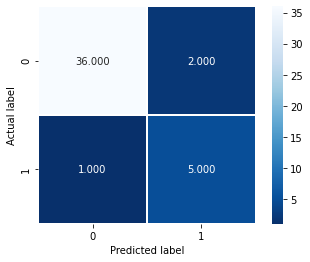

In [77]:
model = SVC(C = 100, gamma = 0.03, kernel = 'rbf')
ttmodel(X, Y, model, 100)

In [78]:
cvmodel(X,Y,model,7)

fit_time = [0.005890369415283203, 0.006377799170357841, 0.006840229034423828]

score_time = [0.010473251342773438, 0.011435576847621374, 0.013987302780151367]

test_f1 = [0.5, 0.7072562358276644, 0.888888888888889]

train_f1 = [0.7777777777777777, 0.8409826045164391, 0.9047619047619048]

test_roc_auc = [0.8333333333333333, 0.916048237476809, 0.9761904761904762]

train_roc_auc = [0.9584615384615385, 0.969542225954186, 0.9892949427833149]

